In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split, TensorDataset, DataLoader
import random
import math
import matplotlib.pyplot as plt
import pandas as pd
import copy


import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
mnist_test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())

mnist_train_loader = DataLoader(mnist_train, batch_size = 256, shuffle=True)
mnist_train_fim_loader = DataLoader(mnist_train, batch_size = 1, shuffle=True) 
mnist_test_loader = DataLoader(mnist_test, batch_size = 20, shuffle=True)

In [4]:
class ConvModelMNIST(nn.Module):
    def __init__(self):
        super(ConvModelMNIST, self).__init__()
        self.net = nn.Sequential( # input [batch_size, 1, 28, 28]
            nn.Conv2d(1, 4, 3),   # [batch_size, 4, 26, 26]
            nn.ReLU(),            #
            nn.MaxPool2d(2),      # [batch_size, 4, 13, 13]
            nn.Conv2d(4, 16, 4),   # [batch_size, 16, 10, 10]
            nn.ReLU(),            #  
            nn.MaxPool2d(2),      # [batch_size, 16, 5, 5]
            nn.Flatten(),         # [batch_size, 400]
            nn.Linear(400,10)     # output [batch_size, 10]
        )
    def forward(self, X):
        return self.net(X)
print(f"ConvModelMNIST tem {sum([p.numel() for p in ConvModelMNIST().parameters()])} parametros")

ConvModelMNIST tem 5090 parametros


In [5]:
def train(model, criterion, optimizer, train_loader, n_epochs=20, mask=None, verbose=True, binary=True, use_scheduler=False):
    loss_list = []
    if use_scheduler:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
    for epc in range(n_epochs):
        for X, y in train_loader:
            optimizer.zero_grad()
            X = X.to(device)
            y = y.to(device)
            out = model.forward(X)
            loss = criterion(out, y)
            loss_list.append(loss.item())
            loss.backward()

            if mask is not None:
                with torch.no_grad():
                    for name, p in model.named_parameters():
                        if name in mask.keys():
                            p.grad *= mask[name]
            
            optimizer.step()
        if (epc%5) == 0 and verbose:
            print(f"Epoch {epc}/{n_epochs}- Loss: {loss.item()}")
        if use_scheduler:
            scheduler.step()
            
    return model, loss_list

In [6]:
def test(model, dataloader, binary=True):
    #model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X, labels in dataloader:
            X, labels = X.to(device), labels.to(device)
            output = model(X)
            predicted = output.argmax(dim=1)
            total += labels.shape[0]
            correct += (predicted == labels).sum().item()

    return correct / total

In [7]:
# model = ConvModel().to(device)
# binary=False
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# criterion = nn.CrossEntropyLoss()
# model, loss_list, test_acc = train(model, criterion, optimizer, train_loader, test_loader, n_epochs=30, mask=None, verbose=True, binary=binary)

In [8]:
def calculate_determinant(fim, concat_mask, const=1, eps=1e-12):
    selected_indices = torch.where(concat_mask.diagonal())[0]
    
    submatrix = fim[selected_indices][:, selected_indices] * const
    diagonal_submatrix = submatrix.diag().diag()
    
    logdet_sub = torch.logdet(submatrix)
    logdet_diag = torch.logdet(diagonal_submatrix)
    
    # se quiser a determinante "direto", pode ainda pegar sign_sub * exp(logdet_sub),
    # mas vale a pena ficar no log
    ratio = logdet_sub - logdet_diag
    
    return (logdet_sub,  # det(submatrix)
            logdet_diag,  # det(diagonal)
            ratio)

In [9]:
def calculate_logdet_ratio_for_indices(fim, indices):
    if len(indices) == 0:
        return 0.0, 0.0, 0.0

    submatrix = fim[indices][:, indices].detach()

    diagonal_submatrix = submatrix.diag().diag() #diagonal matrix with same diagonal as the submatrix
    submatrix_logdet = torch.logdet(submatrix)
    diagonal_logdet = torch.logdet(diagonal_submatrix)

    ratio = submatrix_logdet.item() - diagonal_logdet.item()

    return submatrix_logdet.item(), diagonal_logdet.item(), ratio


def calculate_logdet_ratio_by_layer(fim, concat_mask, layer_boundaries, layer_names):
    selected_indices = torch.where(concat_mask.diagonal())[0]
    results = {}
    start_idx = 0
    for i, boundary in enumerate(layer_boundaries):
        layer_name = layer_names[i]
        layer_indices = torch.arange(start_idx, boundary, device=fim.device)
        layer_selected_indices = layer_indices[ torch.isin(layer_indices, selected_indices) ]
        sub_logdet, diag_logdet, ratio = calculate_logdet_ratio_for_indices(fim, layer_selected_indices)
        results[layer_name] = (sub_logdet, diag_logdet, ratio)
        start_idx = boundary

    return results

In [10]:
def get_fisher_matrix(model, optimizer, criterion, train_loader, mask=None, const=1, mode='norm', verbose=True, binary=True, p=2):
    n_params = sum(p.numel() for p in model.parameters())
    fim = torch.zeros(n_params, n_params, dtype=torch.float64).to(device)
    eps = 1e-8
    
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        out = model(X)
        loss = criterion(out, y)
        loss.backward()
        
        if mask is not None:
            with torch.no_grad():
                for name, param in model.named_parameters():
                    if name in mask.keys():
                        param.grad *= mask[name]

        grad = get_gradient(model)
        fim += (grad @ grad.T)
        optimizer.zero_grad()


    fim = torch.divide(fim, len(train_loader.dataset))
    fim += eps * torch.eye(n_params, dtype=fim.dtype).to(device)
    #fim = torch.divide(fim, len(train_loader)) # olha para a quantidade de batches e não de dados
    layer_boundaries = []
    layer_names = []
    start_idx = 0
    concat_mask = torch.Tensor().to(device)
    for name, param in model.named_parameters():
        end_idx = start_idx + param.numel()
        layer_boundaries.append(end_idx)
        layer_names.append(name)
        start_idx = end_idx
        if mask is not None:
            if name in mask.keys():
                concat_mask = torch.concat((concat_mask, mask[name].ravel()))
            else:
                ones = torch.ones(param.ravel().shape).to(device)
                concat_mask = torch.concat((concat_mask, ones))

    '''
    if mask is not None:
        concat_mask = torch.Tensor().to(device)
        for name, param in mask.items():
            concat_mask = torch.concat((concat_mask, param.ravel()))

    else:
        concat_mask = torch.ones(n_params).to(device).bool()
        #concat_mask = torch.diag(concat_mask).bool()

    '''
    if mask is None:
        concat_mask = torch.ones(n_params).to(device).bool()

    concat_mask = torch.diag(concat_mask)
    if verbose:
        fig = plt.figure(figsize=(15, 15))
        plt.imshow(fim.cpu().detach().numpy(), cmap="viridis", origin="upper")
    
        for boundary in layer_boundaries:
            plt.axhline(y=boundary, color='white', linestyle='--', linewidth=1)
            plt.axvline(x=boundary, color='white', linestyle='--',  linewidth=1)

        #row_idxs, col_idxs = np.where(concat_mask.cpu().numpy())
        chosen_param_dots = torch.argwhere(concat_mask)
        #print(chosen_param_dots)
        x_dots = chosen_param_dots[:,0].cpu().detach().numpy()
        y_dots = chosen_param_dots[:,1].cpu().detach().numpy()
        
        # Overlay scatter markers (e.g., red squares) on True positions
        plt.scatter(x_dots, y_dots, color="red", marker="1", s=5, label="True diag")
        plt.colorbar()
        plt.show()


    if mode == 'log_det':
        det_submatrix, det_diagonal, det_div = calculate_determinant(fim, concat_mask, const=const)
        layer_results = calculate_logdet_ratio_by_layer(fim, concat_mask, layer_boundaries, layer_names)

        if verbose:
            print(f"Fisher matrix (times const) determinant = {det_submatrix.item()}")
            print(f"Diagonal Fisher matrix (times const) determinant = {det_diagonal.item()}")
            print(f"Diagonal det / complete det = {det_div.item()}")

        return fim, (det_submatrix, det_diagonal, det_div, layer_results), concat_mask

    elif mode == 'norm':
        submatrix_norm, diagonal_norm, ratio = calculate_norm_ratio(fim, concat_mask, p)
        layer_results = calculate_norm_ratio_by_layer(fim, concat_mask, layer_boundaries, layer_names, p)
        if verbose:
            print(f"Ticket Fisher matrix submatrix norm = {submatrix_norm.item()}")
            print(f"Diagonal ticket Fisher matrix submatrix norm = {diagonal_norm.item()}")
            print(f"Diagonal norm/ submatrix norm = {ratio.item()}")
            print("-"*30)
            
            for layer_name, (subnorm, out_subnorm, layer_ratio) in layer_results.items():
                print(f"Camada: {layer_name}")
                print(f"  Norma submatriz = {subnorm}")
                print(f"  Norma da diagonal = {out_subnorm}")
                print(f"  Razão = {layer_ratio}")
                print("-"*30)

        return fim, (submatrix_norm, diagonal_norm, ratio, layer_results), concat_mask

    else:
        return fim, concat_mask

In [11]:
def get_gradient(net):
    return torch.cat( list( p.grad.view(-1) for p in net.parameters() ) ).view(-1, 1)

In [12]:
def calculate_norm_ratio_for_indices(fim, indices, p=2):
    if len(indices) == 0:
        return 0.0, 0.0, 0.0

    submatrix = fim[indices][:, indices].detach()

    diagonal_submatrix = torch.diag(torch.diag(submatrix)) #diagonal matrix with same diagonal as the submatrix
    #outside_diagonal_submatrix = submatrix - diagonal_submatrix #submatrix with diagonal values = 0

    submatrix_norm = torch.norm(submatrix, p=p)
    diagonal_norm = torch.norm(diagonal_submatrix, p=p)

    if submatrix_norm < 1e-15:
        ratio = 0.0
    else:
        ratio = diagonal_norm.item() / submatrix_norm.item()

    return submatrix_norm.item(), diagonal_norm.item(), ratio


def calculate_norm_ratio_by_layer(fim, concat_mask, layer_boundaries, layer_names, p=2):
    selected_indices = torch.where(concat_mask.diagonal())[0]
    results = {}
    start_idx = 0
    for i, boundary in enumerate(layer_boundaries):
        layer_name = layer_names[i]
        layer_indices = torch.arange(start_idx, boundary, device=fim.device)
        layer_selected_indices = layer_indices[ torch.isin(layer_indices, selected_indices) ]
        sub_norm, diag_norm, ratio = calculate_norm_ratio_for_indices(fim, layer_selected_indices, p)
        results[layer_name] = (sub_norm, diag_norm, ratio)
        start_idx = boundary

    return results

In [13]:
def calculate_norm_ratio(fim, concat_mask, p=2):
    selected_indices = torch.where(concat_mask.diagonal())[0]
    submatrix = fim[selected_indices][:, selected_indices].detach()
    diagonal_submatrix = torch.diag(torch.diag(submatrix))
    #outside_diagonal_submatrix = submatrix - torch.diag(diagonal_submatrix)
    #print(p)
    submatrix_norm = torch.norm(submatrix, p)
    #outside_diagonal_norm = torch.norm(outside_diagonal_submatrix)
    diagonal_norm = torch.norm(diagonal_submatrix, p)

    if submatrix_norm < 1e-15:
        ratio = 0.0
    else:
        ratio = diagonal_norm/submatrix_norm

    return submatrix_norm, diagonal_norm, ratio

In [14]:
def get_eigenvalue_stats(fim, concat_mask):
    concat_mask = concat_mask.diag()
    eig_value, eig_vector = torch.linalg.eig(fim[concat_mask.bool()][:,concat_mask.bool()])
    real_eig_value = eig_value.to(torch.float)
    max_eig_value = real_eig_value.max().item()
    positive_eig_value = (real_eig_value > 0).sum().item()
    return positive_eig_value, max_eig_value

In [15]:
def prune_weights(model, pruning_percentage):
    mask_dict = {}
    with torch.no_grad():
        for name, param in model.named_parameters():
            if name.split('.')[-1] != 'bias':
                # Calculate the pruning threshold
                #threshold = torch.quantile(param.abs(), pruning_percentage)
                threshold = torch.quantile(param.abs(), pruning_percentage)
                mask = (param.abs() >= threshold).float()
                param *= mask
                mask_dict[name] = mask
    return mask_dict

In [16]:
def train_lottery_ticket(model, criterion, epochs, learning_rate, train_loader, test_loader, fim_loader, binary=True,
                         p = 2,n_iter=4, pruning_percentage=0.2, const=1, mode='norm', verbose=True, save_fim=True, use_scheduler=False):
    output_dict = {"fim_list" : [],
                    "mask_list" : [],
                    "det_list" : [],
                   "mask_same_iter_fim_list": [],
                    "acc_list" : [],
                    "model_list" : [],
                   'positive_eigenvalue': [],
                   'highest_eigen_value': [],
                   "concat_mask": []
    }
    n_params = sum(p.numel() for p in model.parameters())
    #optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    initial_weights = {name: param.clone() for name, param in model.named_parameters()}
    
    if verbose:
        print("Training full model...")
        
    model, loss_list = train(model, criterion, optimizer, train_loader, epochs, verbose=verbose, binary=binary, use_scheduler= use_scheduler)
    output_dict["model_list"].append(copy.deepcopy(model))
    acc_full = test(model, test_loader, binary)
    print(f"Terminou treino 100% - Acc = {acc_full}")
    output_dict["acc_list"].append(acc_full)
    fim, det, concat_mask = get_fisher_matrix(model, optimizer, criterion, fim_loader, const=const, mode=mode, verbose=verbose, binary=binary, p=p)
    if save_fim:
        output_dict["fim_list"].append(fim.cpu())
    output_dict["det_list"].append(det)
    output_dict["concat_mask"].append(concat_mask)
    positive_eig_value, max_eig_value = get_eigenvalue_stats(fim, concat_mask)
    output_dict["positive_eigenvalue"].append(positive_eig_value/concat_mask.diag().sum())
    output_dict["highest_eigen_value"].append(max_eig_value)
    
    if verbose:
        print(f"Accuracy of the full model: {acc_full:.2f}")
        print("-"*30)
        print("Pruning weights...")
 
    mask_dict = prune_weights(model, pruning_percentage)
    output_dict["mask_list"].append(mask_dict)
    
    for i in range(1, n_iter+1):
        if verbose:
            print("Resetting weights...")
            
        with torch.no_grad():
            for name, param in model.named_parameters():
                if name in initial_weights:
                    param.copy_(initial_weights[name])
                    if name in mask_dict.keys():
                        param *= mask_dict[name]
        
        # Retrain pruned model
        #optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)

        
        if verbose:
            print(f"Retraining pruned model - {i+1} ")
            
        model, loss_list = train(model, criterion, optimizer, train_loader, epochs, mask_dict, verbose=verbose, binary=binary, use_scheduler= use_scheduler)
        output_dict["model_list"].append(copy.deepcopy(model))
        acc_pruned = test(model, test_loader, binary)
        print(f"Terminou treino {100- pruning_percentage*i*100}% - Acc = {acc_pruned}")
        output_dict["acc_list"].append(acc_pruned)
        fim, det, concat_mask = get_fisher_matrix(model, optimizer, criterion, fim_loader, mask=mask_dict,const=const, mode=mode, verbose=verbose, binary=binary, p=p)
        output_dict["concat_mask"].append(concat_mask)
        if save_fim:
            output_dict["fim_list"].append(fim.cpu())
        output_dict["det_list"].append(det)
        positive_eig_value, max_eig_value = get_eigenvalue_stats(fim, concat_mask)
        output_dict["positive_eigenvalue"].append(positive_eig_value/concat_mask.diag().sum())
        output_dict["highest_eigen_value"].append(max_eig_value)
        
        if verbose:
            print(f"Accuracy of the pruned model {i+1}: {acc_pruned:.2f}")
            print("-"*30)
        
        if i < n_iter:
            if verbose:
                print("Pruning weights...")
                
            mask_dict = prune_weights(model, pruning_percentage*(i+1))
            output_dict["mask_list"].append(mask_dict)
            #Calcula as razões da FIM durante a mesma iteração, mas utilizando a máscara calculada com relação ao modelo atual
            
    return output_dict

In [17]:
def make_dataframe(output_dict):
    model = output_dict["model_list"][-1]
    det_list = output_dict["det_list"]
    acc_list = output_dict["acc_list"]
    positive_eigenvalue_list = output_dict["positive_eigenvalue"]
    highest_eigenvalue_list = output_dict["highest_eigen_value"]
    
    columns = ["acc", "complete_logdet", "diaognal_logdet","submatrix_ratio", "positive_eigenvalue", "highest_eigen_value"]
    default_cols_number = len(columns)
    for name, param in model.named_parameters():
        columns.append(name)
    
    df_list = [[] for i in range(len(columns))]
    for norm_info, acc, non_zero, high_eigv in zip(det_list, acc_list, positive_eigenvalue_list, highest_eigenvalue_list):
        df_list[0].append(acc)
        if type(norm_info[2]) == torch.Tensor:
            df_list[1].append(norm_info[0].item())
            df_list[2].append(norm_info[1].item())
            df_list[3].append(norm_info[2].item())
            df_list[4].append(non_zero.item())
            df_list[5].append(high_eigv)
        else:
            df_list[1].append(norm_info[0])
            df_list[2].append(norm_info[1])
            df_list[3].append(norm_info[2])
            df_list[4].append(non_zero)
            df_list[5].append(high_eigv)

        for i, (key, value) in enumerate(norm_info[3].items()):
            if type(value[-1]) == torch.Tensor:
                df_list[i+default_cols_number].append(value[-1].item())
            else:
                df_list[i+default_cols_number].append(value[-1])

    # return df_list

    df = pd.DataFrame({columns[i]: df_list[i] for i in range(len(df_list))})

    return df

In [18]:
def make_logdet_plots(output_dict):
    fig, ax = plt.subplots(1,3, figsize=(20,5))
    for i, (fim, mask) in enumerate(zip(output_dict['fim_list'],output_dict['concat_mask'])):
        fim, mask =  fim.to(device), mask.to(device)
        prunned_fim = fim[mask.diag().bool()][:,mask.diag().bool()]
        
        eigvals = torch.linalg.eigvals(prunned_fim).to(torch.float64)
        complete_logdet_cumsum = torch.cumsum(torch.log(eigvals), dim=0).cpu().numpy()
    
        diag = prunned_fim.diag()
        diagonal_log = torch.log(torch.sort(diag, descending=True)[0])
        diagonal_logdet_cumsum = torch.cumsum(diagonal_log, dim=0).cpu().numpy()
    
        diff =   complete_logdet_cumsum - diagonal_logdet_cumsum
    
        ax[0].plot(complete_logdet_cumsum, label= f'{100 - 20*(i)} %')
        ax[1].plot(diagonal_logdet_cumsum, label= f'{100 - 20*(i)} %')
        ax[2].plot(diff, label= f'{100 - 20*(i)} %')
    
        
    ax[0].set_title('Complete  k rank approximation logdet')
    ax[0].legend()
    ax[1].set_title('Diagonal  k rank approximation logdet')
    ax[1].legend()
    ax[2].set_title('Complete - Diagonal k rank approximation logdet')
    ax[2].legend()
    plt.show()

In [19]:
def make_log_logdet_plots(output_dict):
    titles = {0: "Log em y",
             1: "Log em x",
             2: "Log em x e y"}
    for k in range(3):
        fig, ax = plt.subplots(1,3, figsize=(20,5))
        for i, (fim, mask) in enumerate(zip(output_dict['fim_list'],output_dict['concat_mask'])):
            fim, mask =  fim.to(device), mask.to(device)
            prunned_fim = fim[mask.diag().bool()][:,mask.diag().bool()]
                
            eigvals = torch.linalg.eigvals(prunned_fim).to(torch.float64)
            complete_logdet_cumsum = torch.cumsum(torch.log(eigvals), dim=0).cpu().numpy()
            
            diag = prunned_fim.diag()
            diagonal_log = torch.log(torch.sort(diag, descending=True)[0])
            diagonal_logdet_cumsum = torch.cumsum(diagonal_log, dim=0).cpu().numpy()
            
            diff =   complete_logdet_cumsum - diagonal_logdet_cumsum
            if k == 0:
            # LOG EM Y
                ax[0].semilogy(complete_logdet_cumsum*-1, label= f'{100 - 20*(i)} %')
                ax[1].semilogy(diagonal_logdet_cumsum*-1, label= f'{100 - 20*(i)} %')
                ax[2].semilogy(diff * -1, label= f'{100 - 20*(i)} %')
            if k == 1:
            # LOG EM X 
                ax[0].semilogx(complete_logdet_cumsum, label= f'{100 - 20*(i)} %')
                ax[1].semilogx(diagonal_logdet_cumsum, label= f'{100 - 20*(i)} %')
                ax[2].semilogx(diff , label= f'{100 - 20*(i)} %')
        
            # LOG EM AMBOS
            if k == 2:
                ax[0].loglog(complete_logdet_cumsum*-1, label= f'{100 - 20*(i)} %')
                ax[1].loglog(diagonal_logdet_cumsum*-1, label= f'{100 - 20*(i)} %')
                ax[2].loglog(diff * -1, label= f'{100 - 20*(i)} %')
        
        ax[0].set_title('Complete  k rank approximation logdet')
        ax[0].legend()
        ax[1].set_title('Diagonal  k rank approximation logdet')
        ax[1].legend()
        ax[2].set_title('Complete - Diagonal k rank approximation logdet')
        ax[2].legend()
        plt.suptitle(titles[k])
        plt.show()

Terminou treino 100% - Acc = 0.9852


C:\Users\WINDOWS\AppData\Local\Temp\ipykernel_23004\2772101470.py:4: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Copy.cpp:308.)
  real_eig_value = eig_value.to(torch.float)


Terminou treino 95.0% - Acc = 0.9851
Terminou treino 90.0% - Acc = 0.9838
Terminou treino 85.0% - Acc = 0.9869
Terminou treino 80.0% - Acc = 0.9872
Terminou treino 75.0% - Acc = 0.9855
Terminou treino 70.0% - Acc = 0.9853
Terminou treino 65.0% - Acc = 0.9845
Terminou treino 60.0% - Acc = 0.9852
Terminou treino 55.0% - Acc = 0.9841
Terminou treino 50.0% - Acc = 0.9862
Terminou treino 44.99999999999999% - Acc = 0.9863
Terminou treino 39.99999999999999% - Acc = 0.9831
Terminou treino 35.0% - Acc = 0.9776
Terminou treino 30.0% - Acc = 0.9791
Terminou treino 25.0% - Acc = 0.9798
Terminou treino 20.0% - Acc = 0.98
Terminou treino 14.999999999999986% - Acc = 0.9771
Terminou treino 10.0% - Acc = 0.8594
Terminou treino 5.0% - Acc = 0.7511
Terminou treino 0.0% - Acc = 0.1135


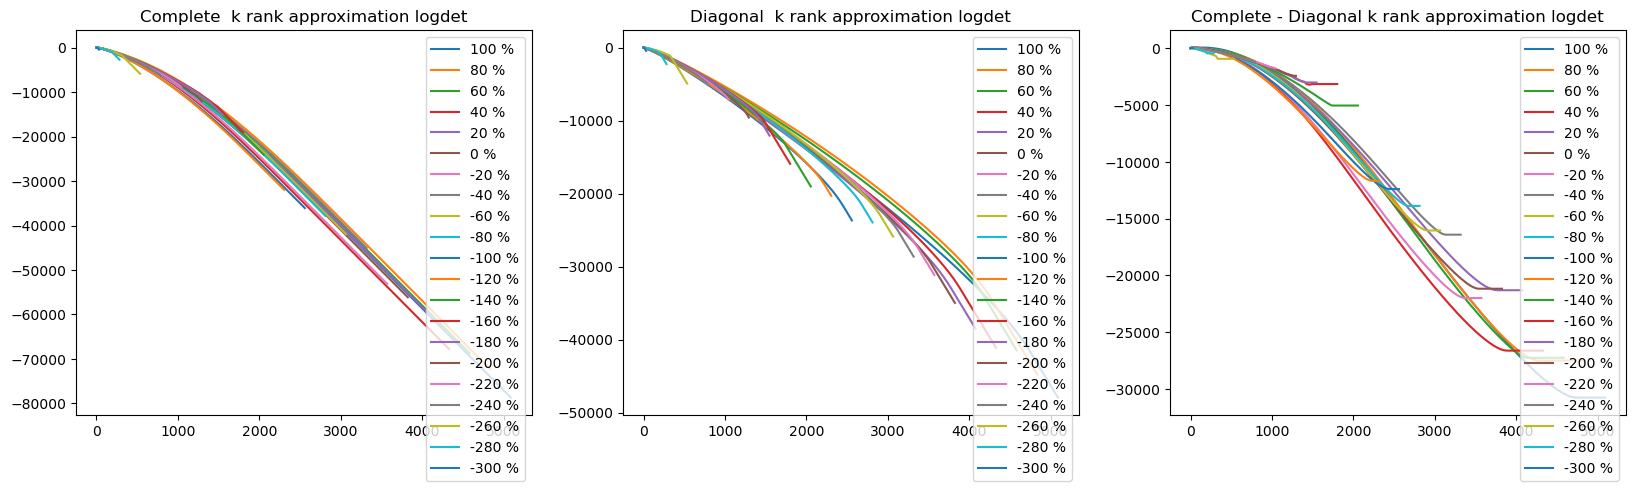

,acc,complete_logdet,diaognal_logdet,submatrix_ratio,positive_eigenvalue,highest_eigen_value,net.0.weight,net.0.bias,net.3.weight,net.3.bias,net.7.weight,net.7.bias
0,0.9852,-78671.820937,-47942.114035,-30729.706903,1.0,1.754374,-35.562168,-0.122500,-2972.620689,-1.984639,-21246.527682,-10.617715
1,0.9851,-72286.950157,-44803.966388,-27482.983769,1.0,3.343168,-21.040320,-0.215035,-1596.094942,-2.268433,-20419.013643,-11.329723
2,0.9838,-68702.106295,-41466.691003,-27235.415292,1.0,2.613774,-17.523512,-0.008444,-1526.554936,-1.676773,-20327.766389,-11.078548
3,0.9869,-67743.031564,-41136.474450,-26606.557114,1.0,1.512129,-20.483142,-0.094908,-1924.920866,-2.506023,-19693.090861,-10.376262
4,0.9872,-59792.464366,-38497.409884,-21295.054482,1.0,1.251135,-15.206711,-0.245586,-1436.481481,-1.855513,-15610.231710,-10.561875
5,0.9855,-56138.763093,-34976.489767,-21162.273326,1.0,1.214931,-14.502750,-0.053619,-1366.833666,-2.506536,-15531.336606,-10.677126
6,0.9853,-53127.700061,-31147.253903,-21980.446158,1.0,1.410247,-16.286151,-0.043493,-1378.514458,-2.267431,-16219.203049,-10.596893
7,0.9845,-45045.747973,-28635.330286,-16410.417687,1.0,1.664313,-14.412713,-0.048699,-944.282747,-2.483751,-11814.938357,-11.045162
8,0.9852,-41930.499139,-25887.751982,-16042.747157,1.0,2.462024,-13.836793,-0.292480,-946.172743,-2.557317,-11348.172224,-10.898811
9,0.9841,-37828.951432,-23946.974207,-13881.977226,1.0,1.537855,-13.294254,-0.495723,-871.223202,-2.227199,-9726.798690,-10.665079


In [20]:
experiment_parameters = {
    "model" : ConvModelMNIST().to(device),
    "criterion" : nn.CrossEntropyLoss(),
    "epochs": 30,
    "learning_rate": 0.01,
    "train_loader": mnist_train_loader,
    "test_loader": mnist_test_loader,
    "fim_loader": mnist_train_fim_loader,
    "binary": False,
    "p": 1,
    "n_iter" : 20,
    "pruning_percentage" : 0.05,
    "const": 1, 
    "mode": 'log_det', 
    "verbose": False,
    "save_fim": True
}
output_dict = train_lottery_ticket(**experiment_parameters)
df = make_dataframe(output_dict)
make_logdet_plots(output_dict)
torch.save(output_dict, 'MNIST_output_dict.pt')
df

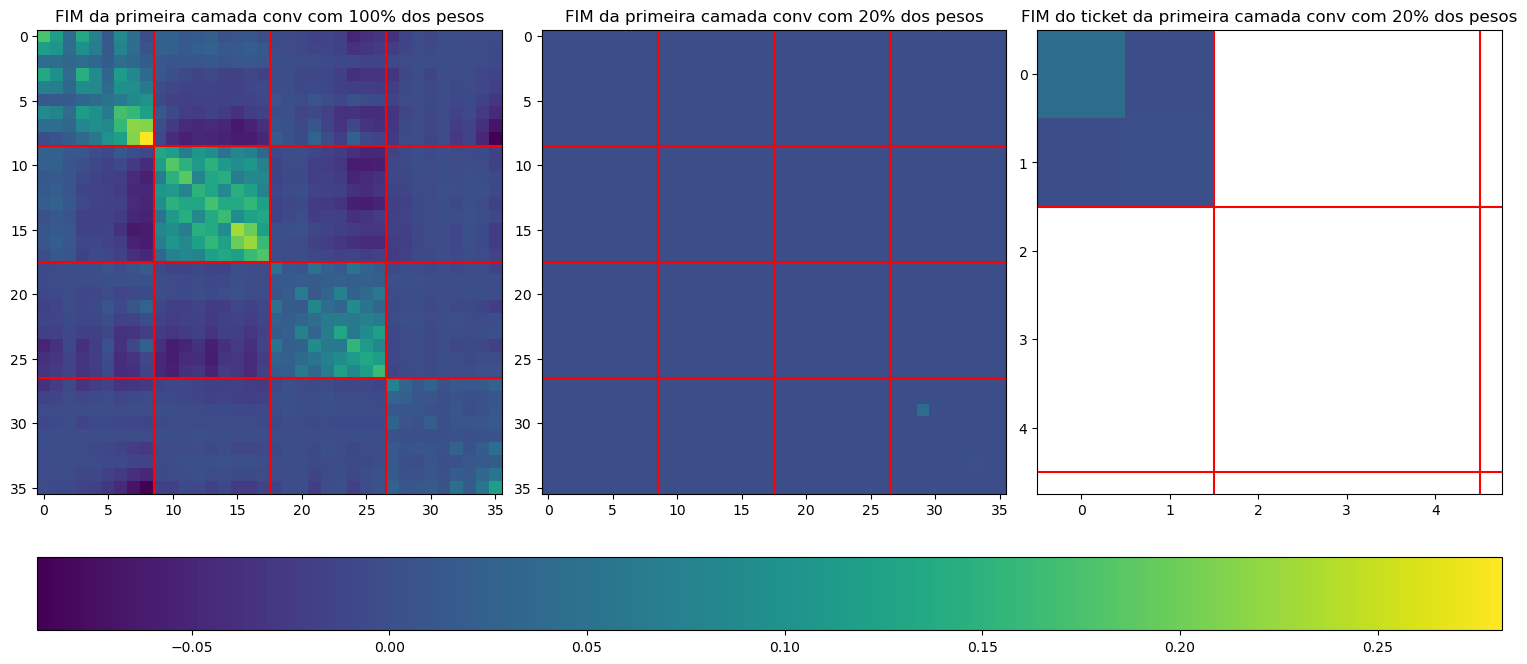

In [31]:
import matplotlib.colors as mcolors
fig, axes = plt.subplots(1, 3, figsize=(15, 8), constrained_layout=True)

complete = output_dict['fim_list'][0][:36, :36].cpu()
final = output_dict['fim_list'][-2][:36, :36].cpu()
vmin = min(complete.min(), final.min())
vmax = max(complete.max(), final.max())
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

axes[0].imshow(complete, norm=norm)
axes[0].axvline(x=8.5, c='r')
axes[0].axvline(x=17.5, c='r')
axes[0].axvline(x=26.5, c='r')
axes[0].axhline(y=8.5, c='r')
axes[0].axhline(y=17.5, c='r')
axes[0].axhline(y=26.5, c='r')
axes[0].set_title('FIM da primeira camada conv com 100% dos pesos')
#axes[0].colorbar()
#plt.show()

final = output_dict['fim_list'][-2][:36, :36].cpu()

im0 = axes[1].imshow(final, norm=norm)
axes[1].axvline(x=8.5, c='r')
axes[1].axvline(x=17.5, c='r')
axes[1].axvline(x=26.5, c='r')
axes[1].axhline(y=8.5, c='r')
axes[1].axhline(y=17.5, c='r')
axes[1].axhline(y=26.5, c='r')
axes[1].set_title('FIM da primeira camada conv com 20% dos pesos')
#axes[1].colorbar()
#plt.show()


aux_bool = output_dict['mask_list'][-2]['net.0.weight'].ravel().bool().cpu()
final_zoom = final[aux_bool][:,aux_bool]
axes[2].imshow(final_zoom, norm=norm)
axes[2].axvline(x=1.5, c='r')
axes[2].axvline(x=4.5, c='r')

axes[2].axhline(y=1.5, c='r')
axes[2].axhline(y=4.5, c='r')
axes[2].set_title('FIM do ticket da primeira camada conv com 20% dos pesos')
#axes[2].colorbar()
cbar = fig.colorbar(im0, ax=axes, orientation='horizontal')
#fig.colorbar()
plt.show()

In [22]:
output_dict['mask_list'][-1]['net.3.weight'].shape

torch.Size([16, 4, 4, 4])

In [33]:
aux_bool = output_dict['mask_list'][-2]['net.3.weight'].ravel().bool().cpu()
len(aux_bool)

1024

In [24]:
for name, p in ConvModelMNIST().named_parameters():
    print(name, p.numel())

net.0.weight 36
net.0.bias 4
net.3.weight 1024
net.3.bias 16
net.7.weight 4000
net.7.bias 10


In [25]:
aux = output_dict['fim_list'][-1][40:1064, 40:1064].cpu()
aux.shape

torch.Size([1024, 1024])

In [26]:
output_dict['mask_list'][-1]['net.3.weight'].shape

torch.Size([16, 4, 4, 4])

In [45]:
ri = output_dict['mask_list'][-3]['net.3.weight'].shape[0]
rj = output_dict['mask_list'][-3]['net.3.weight'].shape[1]
idx_array = []
# for i in range(ri):
#     for j in range(rj):
#         sum_ij = output_dict['mask_list'][-1]['net.3.weight'][i][j].sum().item()
#         idx_array.append(sum_ij)

for i in range(ri):
    sum_ij = output_dict['mask_list'][-3]['net.3.weight'][i].sum().item()
    idx_array.append(sum_ij)
idx_array = torch.tensor(idx_array)
idx_array = idx_array[ idx_array != 0]
idx_array

tensor([14., 14., 14., 13., 14., 11., 10.,  4.,  9.])

In [34]:
aux2 = aux[aux_bool][:,aux_bool]
aux2.shape

torch.Size([52, 52])

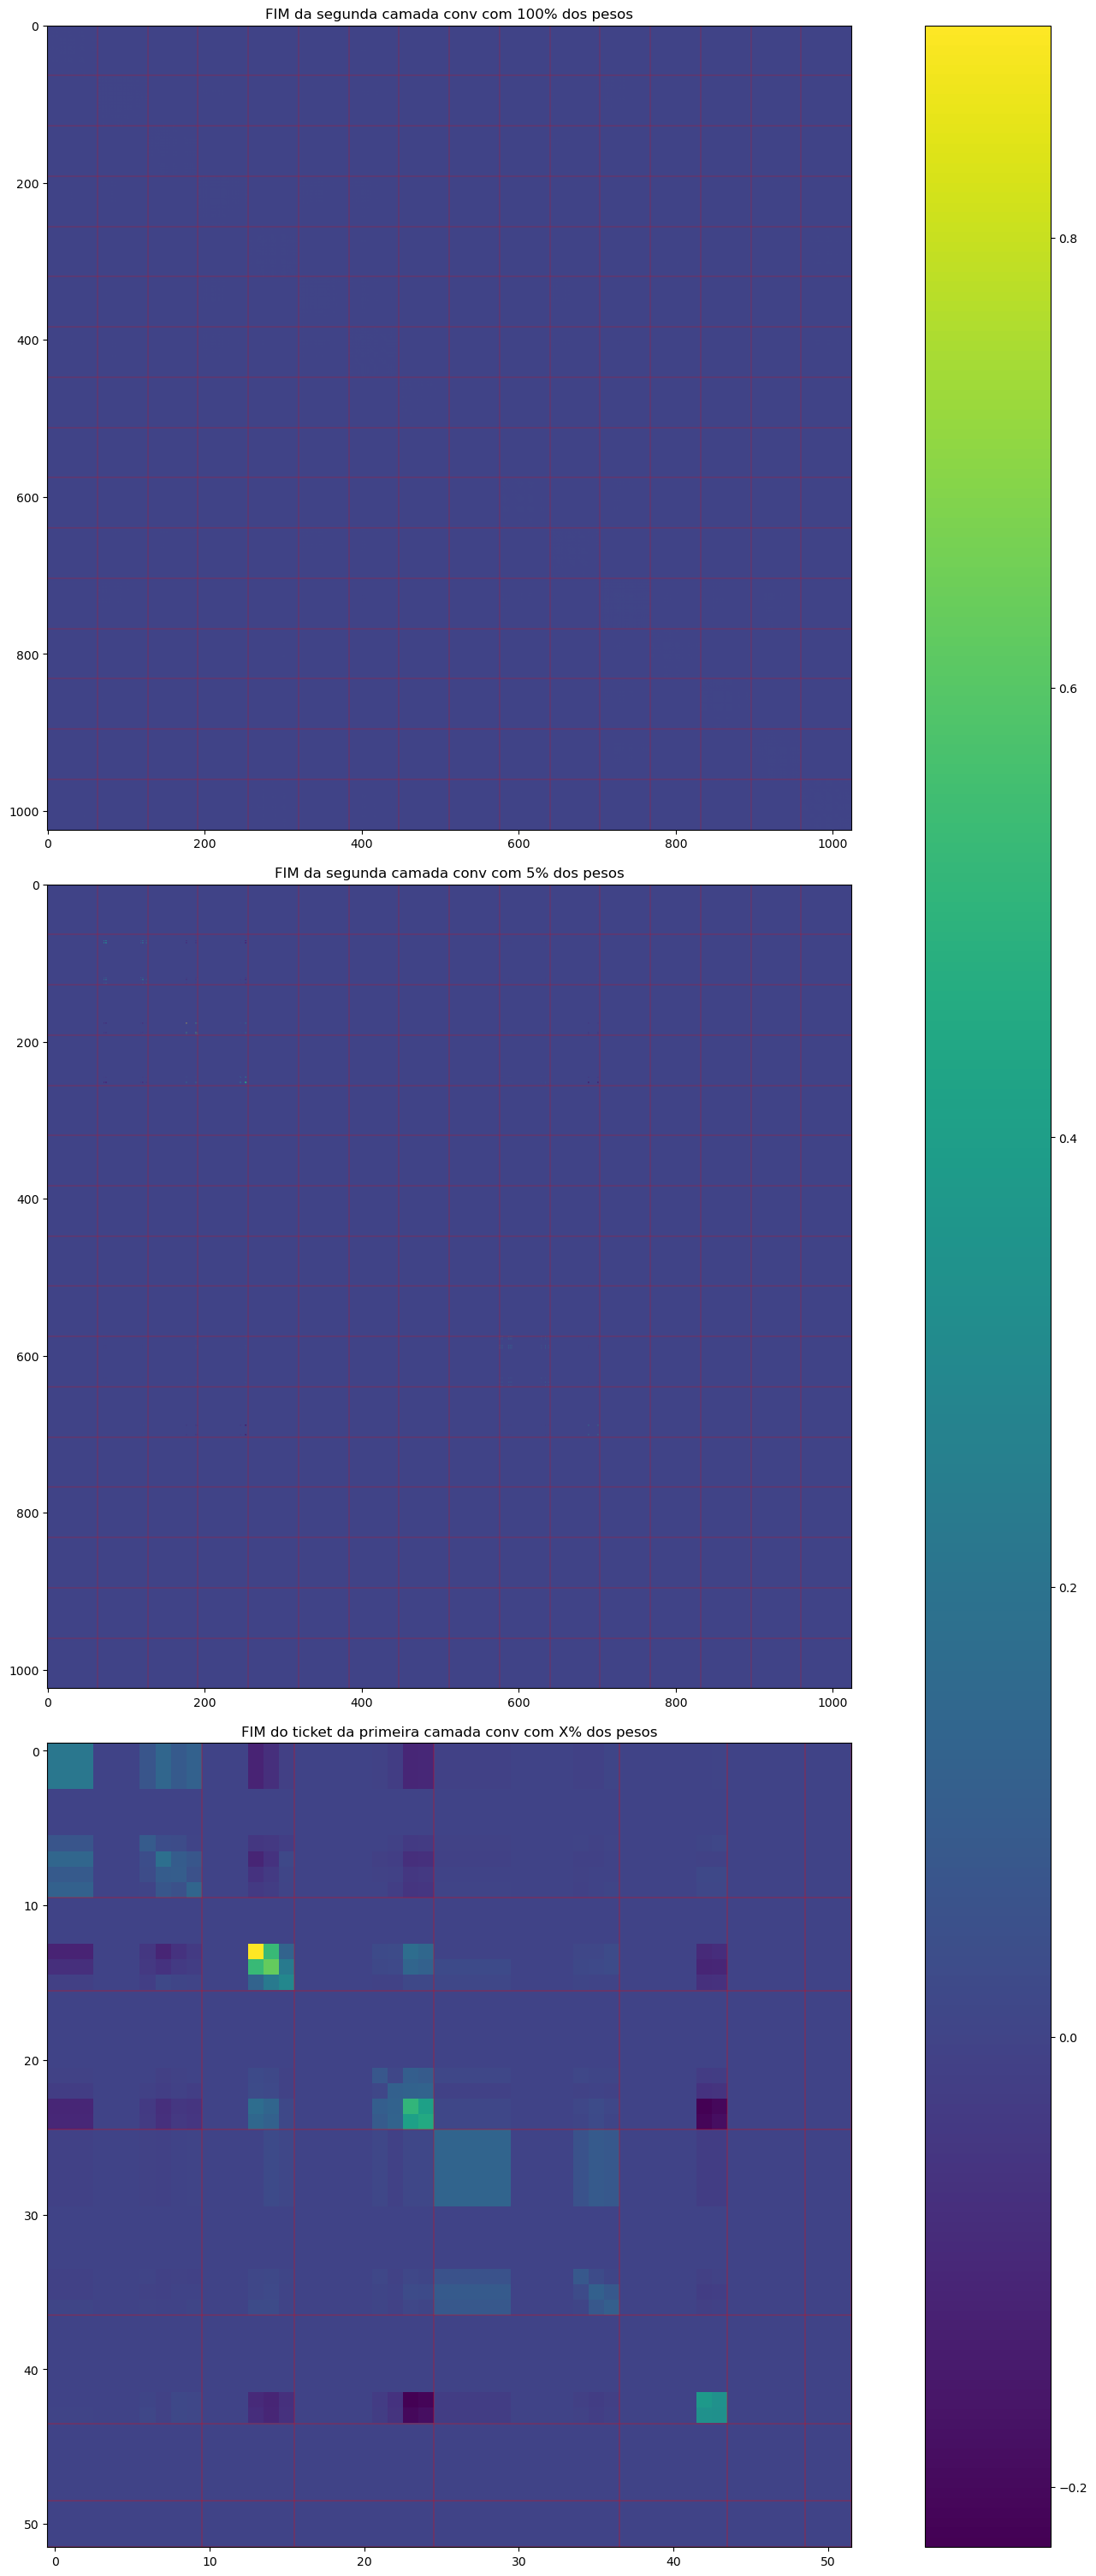

In [52]:
import matplotlib.colors as mcolors
fig, axes = plt.subplots(3, 1, figsize=(20, 30), constrained_layout=True)

prunning_step = -2


ri = output_dict['mask_list'][prunning_step]['net.3.weight'].shape[0]
rj = output_dict['mask_list'][prunning_step]['net.3.weight'].shape[1]
idx_array = []
# for i in range(ri):
#     for j in range(rj):
#         sum_ij = output_dict['mask_list'][-1]['net.3.weight'][i][j].sum().item()
#         idx_array.append(sum_ij)

for i in range(ri):
    sum_ij = output_dict['mask_list'][prunning_step]['net.3.weight'][i].sum().item()
    idx_array.append(sum_ij)
idx_array = torch.tensor(idx_array)
idx_array = idx_array[ idx_array != 0]

aux = output_dict['fim_list'][prunning_step][40:1064, 40:1064].cpu()
aux_bool = output_dict['mask_list'][prunning_step]['net.3.weight'].ravel().bool().cpu()
aux2 = aux[aux_bool][:,aux_bool]

complete = output_dict['fim_list'][0][40:1064, 40:1064].cpu()
final = output_dict['fim_list'][prunning_step][40:1064, 40:1064].cpu()

vmin = min(complete.min(), final.min())
vmax = max(complete.max(), final.max())
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

axes[0].imshow(complete, norm=norm)
for i in range(16):
    val = 64*i
    axes[0].axvline(x=val-0.5, c='r', linewidth=0.2)
    axes[0].axhline(y=val-0.5, c='r', linewidth=0.2)
axes[0].set_title('FIM da segunda camada conv com 100% dos pesos')
#axes[0].colorbar()
#plt.show()

im0 = axes[1].imshow(final, norm=norm)
for i in range(16):
    val = 64*i
    axes[1].axvline(x=val-0.5, c='r', linewidth=0.2)
    axes[1].axhline(y=val-0.5, c='r', linewidth=0.2)
axes[1].set_title('FIM da segunda camada conv com 5% dos pesos')
#axes[1].colorbar()
#plt.show()

aux2 = aux[aux_bool][:,aux_bool]
axes[2].imshow(aux2)
for i in torch.cumsum(idx_array, dim=0):
    axes[2].axvline(x=i-0.5, c='r', linewidth=0.3)
    axes[2].axhline(y=i-0.5, c='r', linewidth=0.3)
axes[2].set_title('FIM do ticket da primeira camada conv com X% dos pesos')

cbar = fig.colorbar(im0, ax=axes, orientation='vertical')
#fig.colorbar()
plt.show()

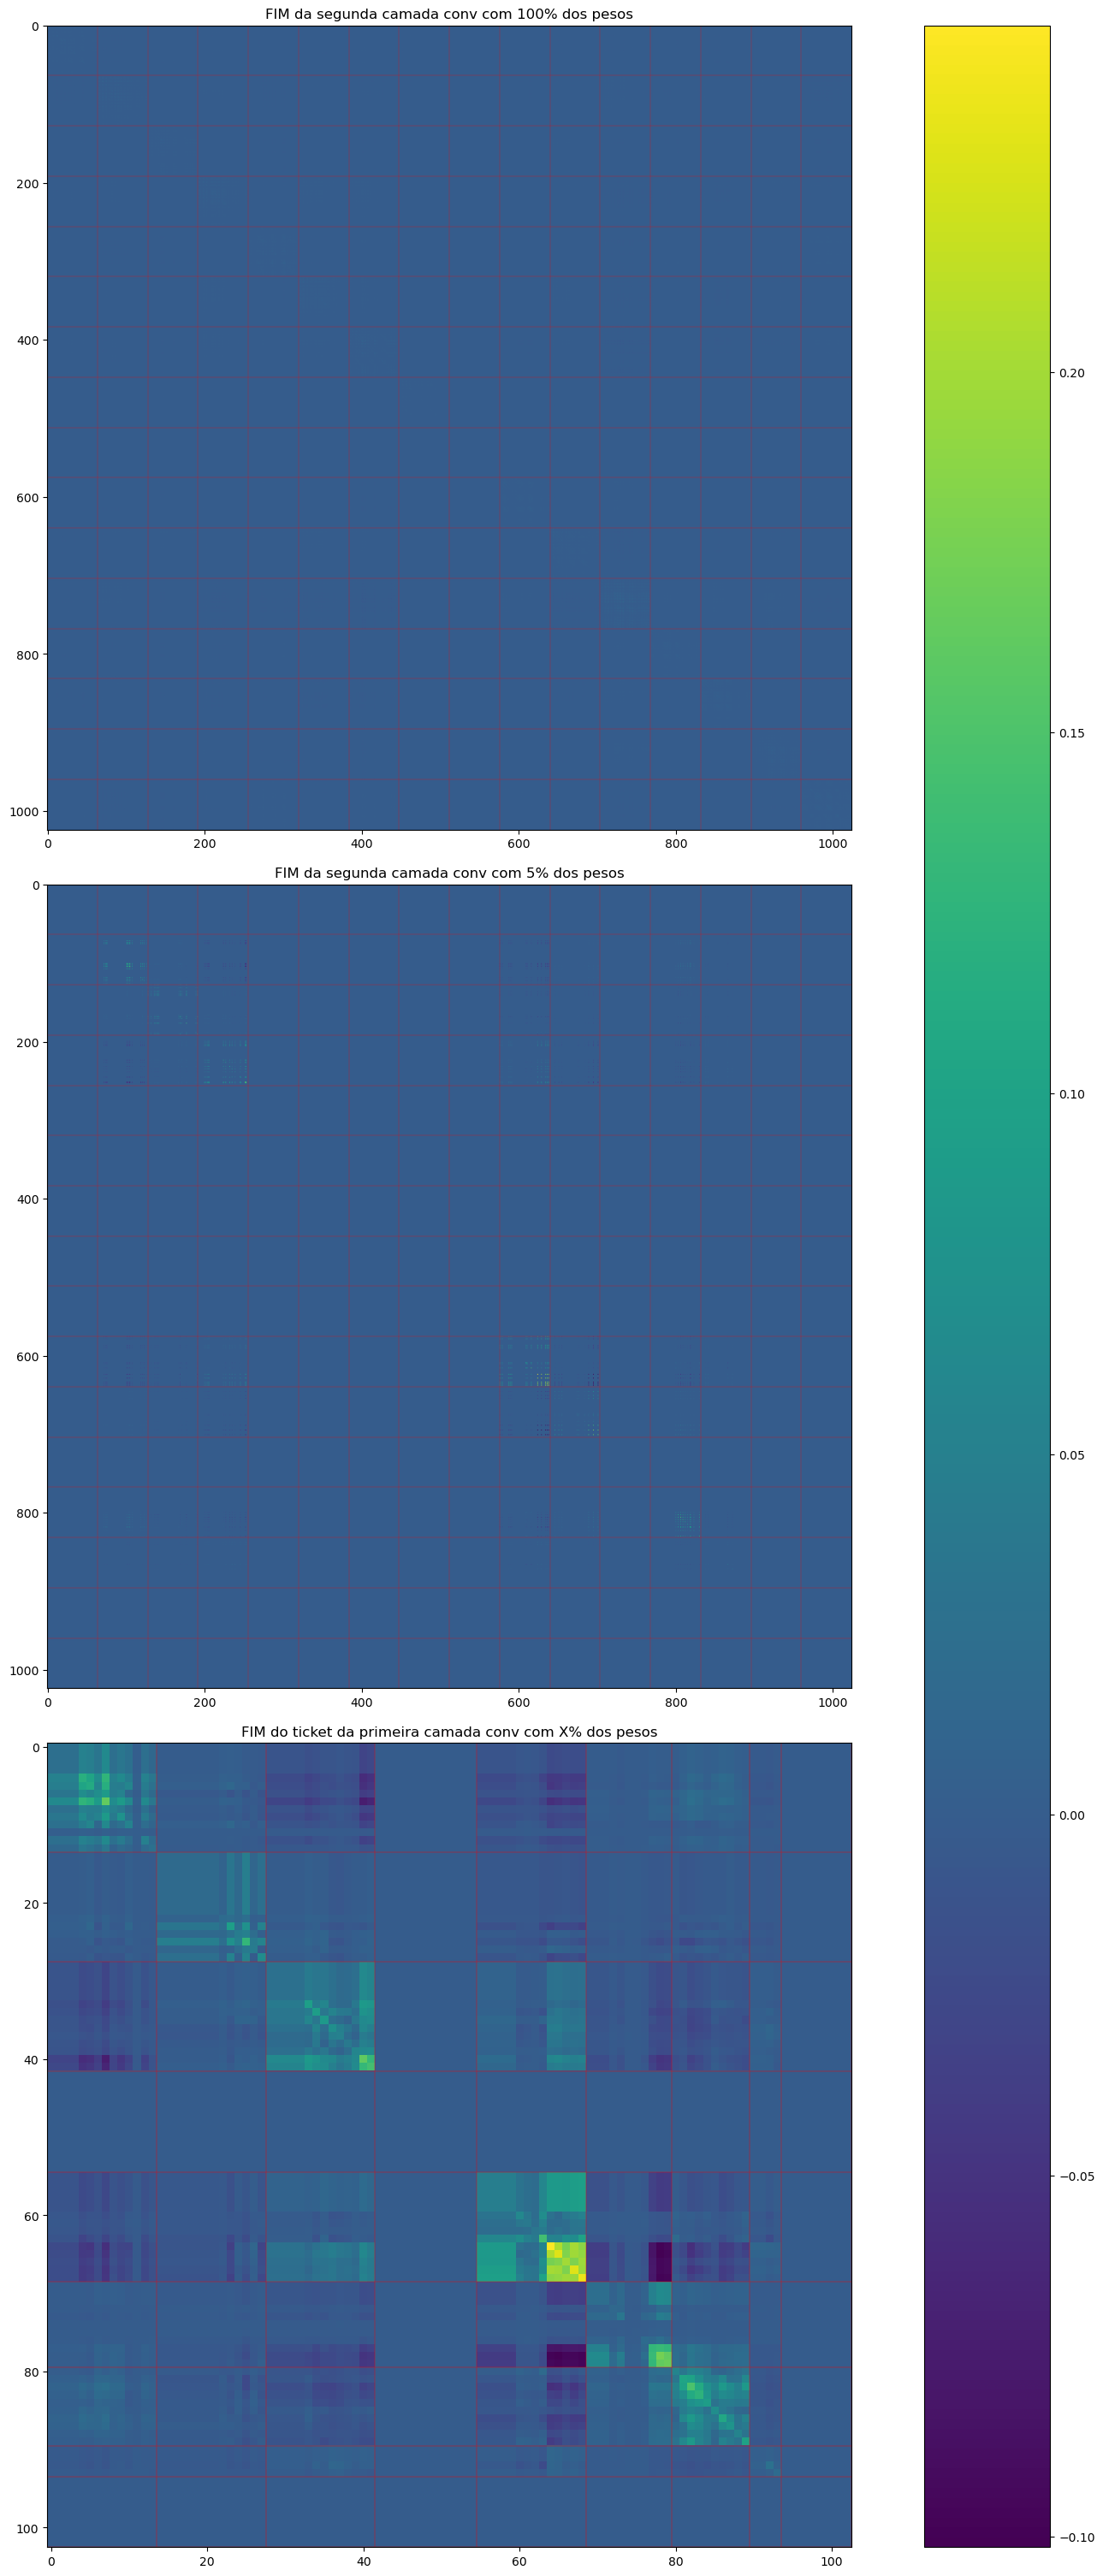

In [53]:
import matplotlib.colors as mcolors
fig, axes = plt.subplots(3, 1, figsize=(20, 30), constrained_layout=True)

prunning_step = -3


ri = output_dict['mask_list'][prunning_step]['net.3.weight'].shape[0]
rj = output_dict['mask_list'][prunning_step]['net.3.weight'].shape[1]
idx_array = []
# for i in range(ri):
#     for j in range(rj):
#         sum_ij = output_dict['mask_list'][-1]['net.3.weight'][i][j].sum().item()
#         idx_array.append(sum_ij)

for i in range(ri):
    sum_ij = output_dict['mask_list'][prunning_step]['net.3.weight'][i].sum().item()
    idx_array.append(sum_ij)
idx_array = torch.tensor(idx_array)
idx_array = idx_array[ idx_array != 0]

aux = output_dict['fim_list'][prunning_step][40:1064, 40:1064].cpu()
aux_bool = output_dict['mask_list'][prunning_step]['net.3.weight'].ravel().bool().cpu()
aux2 = aux[aux_bool][:,aux_bool]

complete = output_dict['fim_list'][0][40:1064, 40:1064].cpu()
final = output_dict['fim_list'][prunning_step][40:1064, 40:1064].cpu()

vmin = min(complete.min(), final.min())
vmax = max(complete.max(), final.max())
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

axes[0].imshow(complete, norm=norm)
for i in range(16):
    val = 64*i
    axes[0].axvline(x=val-0.5, c='r', linewidth=0.2)
    axes[0].axhline(y=val-0.5, c='r', linewidth=0.2)
axes[0].set_title('FIM da segunda camada conv com 100% dos pesos')
#axes[0].colorbar()
#plt.show()

im0 = axes[1].imshow(final, norm=norm)
for i in range(16):
    val = 64*i
    axes[1].axvline(x=val-0.5, c='r', linewidth=0.2)
    axes[1].axhline(y=val-0.5, c='r', linewidth=0.2)
axes[1].set_title('FIM da segunda camada conv com 5% dos pesos')
#axes[1].colorbar()
#plt.show()

aux2 = aux[aux_bool][:,aux_bool]
axes[2].imshow(aux2)
for i in torch.cumsum(idx_array, dim=0):
    axes[2].axvline(x=i-0.5, c='r', linewidth=0.3)
    axes[2].axhline(y=i-0.5, c='r', linewidth=0.3)
axes[2].set_title('FIM do ticket da primeira camada conv com X% dos pesos')

cbar = fig.colorbar(im0, ax=axes, orientation='vertical')
#fig.colorbar()
plt.show()

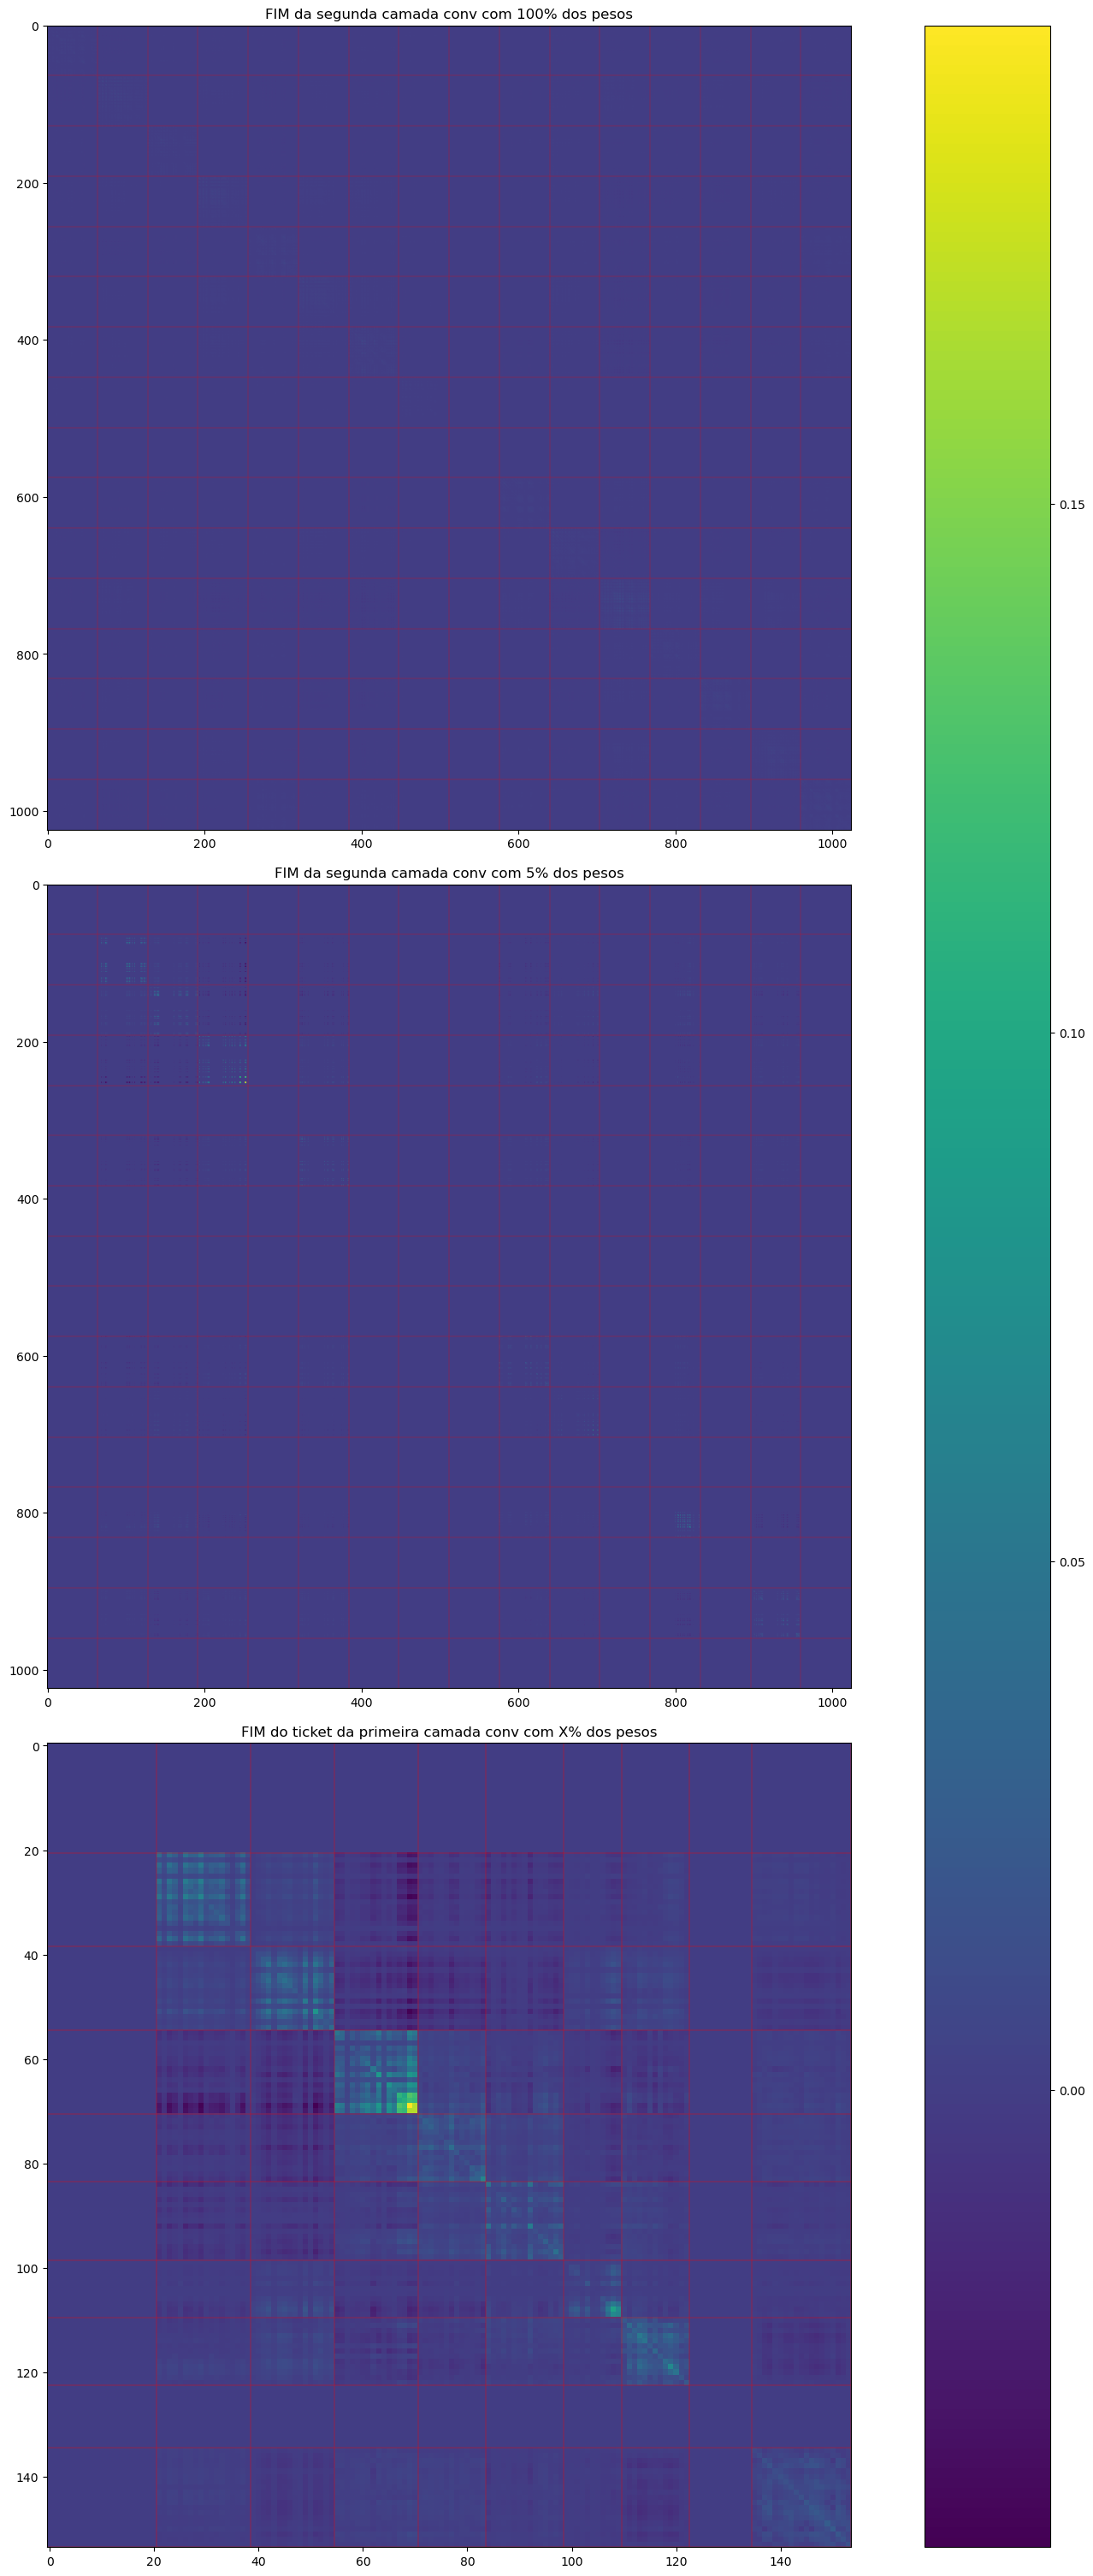

In [54]:
import matplotlib.colors as mcolors
fig, axes = plt.subplots(3, 1, figsize=(20, 30), constrained_layout=True)

prunning_step = -4


ri = output_dict['mask_list'][prunning_step]['net.3.weight'].shape[0]
rj = output_dict['mask_list'][prunning_step]['net.3.weight'].shape[1]
idx_array = []
# for i in range(ri):
#     for j in range(rj):
#         sum_ij = output_dict['mask_list'][-1]['net.3.weight'][i][j].sum().item()
#         idx_array.append(sum_ij)

for i in range(ri):
    sum_ij = output_dict['mask_list'][prunning_step]['net.3.weight'][i].sum().item()
    idx_array.append(sum_ij)
idx_array = torch.tensor(idx_array)
idx_array = idx_array[ idx_array != 0]

aux = output_dict['fim_list'][prunning_step][40:1064, 40:1064].cpu()
aux_bool = output_dict['mask_list'][prunning_step]['net.3.weight'].ravel().bool().cpu()
aux2 = aux[aux_bool][:,aux_bool]

complete = output_dict['fim_list'][0][40:1064, 40:1064].cpu()
final = output_dict['fim_list'][prunning_step][40:1064, 40:1064].cpu()

vmin = min(complete.min(), final.min())
vmax = max(complete.max(), final.max())
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

axes[0].imshow(complete, norm=norm)
for i in range(16):
    val = 64*i
    axes[0].axvline(x=val-0.5, c='r', linewidth=0.2)
    axes[0].axhline(y=val-0.5, c='r', linewidth=0.2)
axes[0].set_title('FIM da segunda camada conv com 100% dos pesos')
#axes[0].colorbar()
#plt.show()

im0 = axes[1].imshow(final, norm=norm)
for i in range(16):
    val = 64*i
    axes[1].axvline(x=val-0.5, c='r', linewidth=0.2)
    axes[1].axhline(y=val-0.5, c='r', linewidth=0.2)
axes[1].set_title('FIM da segunda camada conv com 5% dos pesos')
#axes[1].colorbar()
#plt.show()

aux2 = aux[aux_bool][:,aux_bool]
axes[2].imshow(aux2)
for i in torch.cumsum(idx_array, dim=0):
    axes[2].axvline(x=i-0.5, c='r', linewidth=0.3)
    axes[2].axhline(y=i-0.5, c='r', linewidth=0.3)
axes[2].set_title('FIM do ticket da primeira camada conv com X% dos pesos')

cbar = fig.colorbar(im0, ax=axes, orientation='vertical')
#fig.colorbar()
plt.show()

In [55]:
def to_correlation(A: torch.Tensor, eps: float = 0):
    """
    A: (..., n, n) SPD (real simétrica).
    Retorna C = D^{-1/2} A D^{-1/2} com diag(C)=1.
    eps: opcional p/ estabilidade (raramente necessário em SPD bem condicionado).
    """
    assert A.size(-1) == A.size(-2)
    d = torch.diagonal(A, dim1=-2, dim2=-1)  # (..., n)
    if eps > 0:
        d = d + eps
    inv_sqrt_d = 1.0 / torch.sqrt(d)
    # constrói D^{-1/2} como diagonal batelada
    Dinv2 = torch.diag_embed(inv_sqrt_d)     # (..., n, n)
    C = Dinv2 @ A @ Dinv2
    return C

0 0.0014090512811740937 1.0888400428369367e-07 7.727469236815512e-05
1 0.0014900278224452268 1.5634910095242697e-07 0.00010493032317741736
2 0.005097460494224496 2.223066226924116e-07 4.36112497476605e-05
3 0.004807889153985135 2.165968142025813e-07 4.505029281365324e-05
4 0.008504169812524299 6.966944678493051e-07 8.192386596316018e-05
5 0.009777215865391223 8.693935942792047e-07 8.89203640636452e-05
6 0.007608399990720841 1.3559260788733987e-06 0.00017821435262697043
7 0.004554910385388519 8.882670338650232e-07 0.00019501306473878908
8 0.011298244487273262 2.164860755214902e-06 0.0001916103654557668
9 0.03608512296465581 6.1713747449645035e-06 0.00017102268851928136
10 0.07101590204908301 5.164654970043622e-06 7.272533082060567e-05
11 0.11235665859494381 9.490159799085032e-06 8.446459620422868e-05
12 0.1088737281929405 1.6394109615018677e-05 0.00015057911478853664
13 0.0930097766446788 3.070471429873569e-05 0.00033012351396167827
14 0.12024459050387158 5.558364484126825e-05 0.0004622

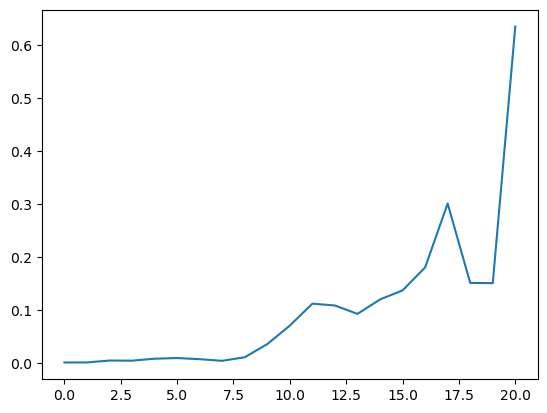

In [60]:
logdet_list = []
for i, (fim, mask) in enumerate(zip(output_dict['fim_list'], output_dict['concat_mask'])):
    out = to_correlation(fim)
    mask = mask.cpu().diag().bool()
    out = out[mask][:,mask]
    fim = fim[mask][:,mask]
    full_logdet = torch.logdet(out)
    diag_logdet = torch.logdet(torch.diag(torch.diag(out)))
    logdet_list.append(torch.exp(full_logdet/out.shape[0]).item())
    print(i, torch.exp(full_logdet/out.shape[0]).item(), torch.exp(torch.logdet(fim)/out.shape[0]).item(), torch.exp(torch.logdet(fim.diag().diag())/out.shape[0]).item())
plt.plot(logdet_list)